# Raw data for top tagging
This notebook reads in the smaller dataset that was generated from `Tutorial3_0_TopTagging_ProcessRawData.ipynb`

In [1]:
import os
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# The commands make the plots look nice
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'font.serif': 'cmr10',
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'figure.figsize': (3, 3),
                     'figure.dpi': 80,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True,
                     'axes.formatter.use_mathtext': True
                     })

**Description**

 * 14 TeV, hadronic tops for signal, qcd diets background, delphes ATLAS detector card with pythia 
 * No MPI/pile-up included
 * We cluster particle-flow entries (produced by Delphes E-flow) into anti-kT 0.8 jets in the pT range [550,650]
 * All top jets are matched to a parton-level top within ∆R = 0.8, and to all top decay partons within 0.8
 * We also require |eta|_jet < 2
 * The leading 200 jet constituent four-momenta are stored, with zero-padding for jets with fewer than 200 (actually this is most of them, so maybe this could be lowered)
 * Constituents are sorted by pT, with the highest pT one first
 * The truth top four-momentum is stored as truth_px etc.
 * A flag (1 for top, 0 for QCD) is kept for each jet. It is called is_signal_new
 * The variable "ttv" (= test/train/validation) is kept for each jet. It indicates to which dataset the jet belongs. It is redundant as the different sets are already distributed as different files.


## Training Data

In [3]:
training_data_html = 'https://www.dropbox.com/s/c4bghtrmslt6sgg/training_events.npy?dl=0'
training_labels_html = 'https://www.dropbox.com/s/8rskjcoq8io1j3h/training_labels.npy?dl=0'

Checks to see if the files exist, if not, it downloads them from Bryan's dropbox.

In [4]:
train_file = '../data/top_tagging/smaller_raw/training_events.npy'
if not os.path.isfile(train_file):
    urllib.request.urlretrieve(training_data_html, filename=train_file)
    
train_label_file = '../data/top_tagging/smaller_raw/training_labels.npy'
if not os.path.isfile(train_label_file):
    urllib.request.urlretrieve(training_labels_html, filename=train_label_file)

In [5]:
training_events = np.load(train_file)
training_labels = np.load(train_label_file)

If the above code is not working, use the htmls above to dowload the data directly.

In [6]:
print(training_events.shape, training_labels.shape)

(200000, 100, 4) (200000, 1)


One of the big question in machine learning is how the data should be represented. Each event here contains 100 four vectors (many of them may be 0). We would like to find other representations which will allow us to analyze the data easier.

## Validation

In [7]:
val_data_html = 'https://www.dropbox.com/s/4251d60timdgc6w/val_events.npy?dl=0'
val_labels_html = 'https://www.dropbox.com/s/grg69wn73j6az5l/val_labels.npy?dl=0'

In [8]:
val_file = '../data/top_tagging/smaller_raw/val_events.npy'
if not os.path.isfile(val_file):
    urllib.request.urlretrieve(val_data_html, filename=val_file)
    
val_label_file = '../data/top_tagging/smaller_raw/val_labels.npy'
if not os.path.isfile(val_label_file):
    urllib.request.urlretrieve(val_labels_html, filename=val_label_file)

In [9]:
val_events = np.load(val_file)
val_labels = np.load(val_label_file)

In [10]:
print(val_events.shape, val_labels.shape)

(20000, 100, 4) (20000, 1)


## Testing

In [11]:
test_data_html = 'https://www.dropbox.com/s/4orb8yjn8es1akf/test_events.npy?dl=0'
test_labels_html = 'https://www.dropbox.com/s/w8gvrhrpdaqe1e8/test_labels.npy?dl=0'

In [12]:
test_file = '../data/top_tagging/smaller_raw/test_events.npy'
if not os.path.isfile(test_file):
    urllib.request.urlretrieve(test_data_html, filename=test_file)
    
test_label_file = '../data/top_tagging/smaller_raw/test_labels.npy'
if not os.path.isfile(test_label_file):
    urllib.request.urlretrieve(test_label_file, filename=test_label_file)

In [13]:
test_events = np.load(test_file)
test_labels = np.load(test_label_file)

In [14]:
print(test_events.shape, test_labels.shape)

(20000, 100, 4) (20000, 1)


# Representations
Currently, the data has 100 four vectors for each event. However, are they represented as ($p_T$, $\eta$, $\phi$, $m$) or are they as ($E$, $p_x$, $p_y$, $p_z$)? Let's make some histograms to find out. We will do this with the validation set since the number of events is smaller.

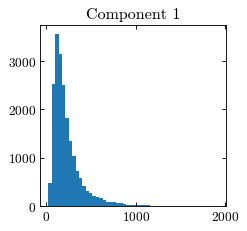

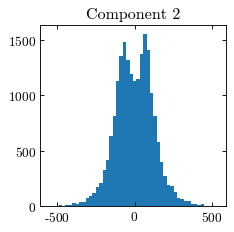

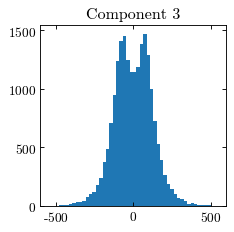

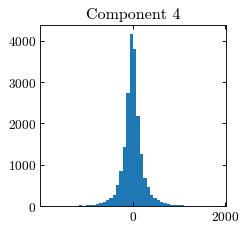

In [15]:
# Let's look at the hardest object in each event
for i in range(4):  # scan over the four vector components
    plt.hist(val_events[:, 0, i], bins=50)
    plt.title(f"Component {i+1}")
    plt.show()

We see that the first component has only positive values, while the other components are roughly symmetric about 0. Notice also that none of the values looks like an angle (the ranges are not bounded by $\pi$ or $2\pi$. With this, we should use the $(E, p_x, p_y, p_z)$ basis. This can also be confirmed in the previous notebook. In tutorial 2, when we used PyJet, the data used the other representation. We will have to adjust the code a little.

## Subjet basis

In [16]:
from pyjet import cluster,DTYPE_EP

In [17]:
def DeltaPhi(obj_1, obj_2):
    '''
    Calculates the delta phi, with values between -pi and pi
    inputs should be a list with a length of 3
    
    arguments:
    obj_1 = [pt, eta, phi]
    obj_2 = [pt, eta, phi]
    
    returns:
    deltaphi -- float for the angular distance
    '''
    pt1, eta1, phi1 = obj_1
    pt2, eta2, phi2 = obj_2
    deltaphi = phi1 - phi2
    if deltaphi > np.pi:
        deltaphi = (-2 * np.pi) + deltaphi
    return deltaphi


def DeltaR(obj_1, obj_2):
    '''
    Calculates the delta R
    inputs should be a list with a length of 3
    obj_1 = [pt, eta, phi]
    obj_2 = [pt, eta, phi]
    '''
    pt1, eta1, phi1 = obj_1
    pt2, eta2, phi2 = obj_2
    dr = np.sqrt(np.square(eta1 - eta2) + np.square(DeltaPhi(obj_1, obj_2)))
    return dr

In [18]:
def NSubjettiness(constituents, axes, beta, jetpt):
    '''
    Computes the n-subjettines
    
    Arguments:
    constituents -- an array of pseudovectors
    axes -- an array of pseudovectors
    jetpt -- the overall transverse momentum of the jet
        
    Returns:
    tau[0.5] -- n-subjets with the power of 0.5
    tau[1] -- n-subjets with the power of 1
    tau[2] -- n-subjets with the power of 2
    '''
    tau = {0.5: 0.0,
           1: 0.0,
           2: 0.0
           }  # starting values for different betas
    for particle in constituents:
        for beta in [0.5, 1, 2]:
            dr = np.min([np.power(DeltaR([particle.pt, particle.eta, particle.phi],
                                         [axis.pt, axis.eta, axis.phi]), beta) for axis in axes])
            tau[beta] += particle.pt * dr
    for beta in [0.5, 1, 2]:
        tau[beta] = tau[beta] / jetpt

    return tau[0.5], tau[1], tau[2]

In [19]:
cluster?

Signature: cluster(vectors, algo='genkt', area=None, ep=False, **kwargs)
Docstring:
Perform jet clustering on a numpy array of 4-vectors in (pT, eta, phi,
mass) representation, otherwise (E, px, py, pz) representation if ep=True

Parameters
----------

vectors: np.ndarray or PseudoJet
    Array of 4-vectors or a PseudoJet in which case the PseudoJet
    constituents are used as inputs to the jet clustering
algo: JetDefinition or str (optional, default='genkt')
    The jet definition as a JetDefinition or a string naming the jet
    algorithm in which case the additional keywork arguments are used to
    construct the JetDefinition
area: str (optional, default=None)
    The type of jet area to compute
ep: bool (optional, default=False)
    First four fields of ``vectors`` are (pT, eta, phi, mass) if ep=False
    or (E, px, py, pz) if ep=True

Returns
-------

sequence : ClusterSequence
    A wrapped fastjet::ClusterSequence
File:      /opt/conda/lib/python3.9/site-packages/pyjet/__init_

These computations take around 30 minutes on my computer, we will save the output so we don't have to recompute them each time.

In [20]:
NSubjettinessData = []

for jet_consituents in tqdm(training_events):
    pseudojets_input = np.zeros(len([x for x in jet_consituents[::4] if x[0] > 0]), dtype=DTYPE_EP)
    
    for j in range(pseudojets_input.shape[0]):
        pseudojets_input[j]['E'] = jet_consituents[j, 0]
        pseudojets_input[j]['px'] = jet_consituents[j, 1]
        pseudojets_input[j]['py'] = jet_consituents[j, 2]
        pseudojets_input[j]['pz'] = jet_consituents[j, 3]

    sequence = cluster(pseudojets_input, R=1, p=1, ep=True)
    jet = sequence.exclusive_jets(1)[0]
    NSubjet = {}
    for pronginess in range(1, 5):
        # undo the clustering to a specific number of jets
        if len(jet.constituents()) > pronginess:
            axes = sequence.exclusive_jets(pronginess)
            nsubjettiness = NSubjettiness(jet.constituents(), axes,
                                          pronginess, jet.pt
                                         )
            NSubjet['{0}_0.5'.format(pronginess)] = nsubjettiness[0]
            NSubjet['{0}_1'.format(pronginess)] = nsubjettiness[1]
            NSubjet['{0}_2'.format(pronginess)] = nsubjettiness[2]
        else:
            NSubjet['{0}_0.5'.format(pronginess)] = 0
            NSubjet['{0}_1'.format(pronginess)] = 0
            NSubjet['{0}_2'.format(pronginess)] = 0
            
    tmp_entry = [jet.pt,
                 NSubjet['1_0.5'], NSubjet['1_1'], NSubjet['1_2'],
                 NSubjet['2_0.5'], NSubjet['2_1'], NSubjet['2_2'],
                 NSubjet['3_0.5'], NSubjet['3_1'], NSubjet['3_2'],
                 NSubjet['4_1'], NSubjet['4_2']
                ]
    NSubjettinessData.append(tmp_entry)
NSubjettinessData = np.array(NSubjettinessData)

100% 200000/200000 [33:38<00:00, 99.07it/s]  


In [21]:
NSubjettinessValData = []

for jet_consituents in tqdm(val_events):
    pseudojets_input = np.zeros(len([x for x in jet_consituents[::4] if x[0] > 0]), dtype=DTYPE_EP)
    
    for j in range(pseudojets_input.shape[0]):
        pseudojets_input[j]['E'] = jet_consituents[j, 0]
        pseudojets_input[j]['px'] = jet_consituents[j, 1]
        pseudojets_input[j]['py'] = jet_consituents[j, 2]
        pseudojets_input[j]['pz'] = jet_consituents[j, 3]

    sequence = cluster(pseudojets_input, R=1, p=1, ep=True)
    jet = sequence.exclusive_jets(1)[0]
    NSubjet = {}
    for pronginess in range(1, 5):
        # undo the clustering to a specific number of jets
        if len(jet.constituents()) > pronginess:
            axes = sequence.exclusive_jets(pronginess)
            nsubjettiness = NSubjettiness(jet.constituents(), axes,
                                          pronginess, jet.pt
                                         )
            NSubjet['{0}_0.5'.format(pronginess)] = nsubjettiness[0]
            NSubjet['{0}_1'.format(pronginess)] = nsubjettiness[1]
            NSubjet['{0}_2'.format(pronginess)] = nsubjettiness[2]
        else:
            NSubjet['{0}_0.5'.format(pronginess)] = 0
            NSubjet['{0}_1'.format(pronginess)] = 0
            NSubjet['{0}_2'.format(pronginess)] = 0
            
    tmp_entry = [jet.pt,
                 NSubjet['1_0.5'], NSubjet['1_1'], NSubjet['1_2'],
                 NSubjet['2_0.5'], NSubjet['2_1'], NSubjet['2_2'],
                 NSubjet['3_0.5'], NSubjet['3_1'], NSubjet['3_2'],
                 NSubjet['4_1'], NSubjet['4_2']
                ]
    NSubjettinessValData.append(tmp_entry)
NSubjettinessValData = np.array(NSubjettinessValData)

100% 20000/20000 [03:20<00:00, 99.55it/s] 


In [22]:
NSubjettinessTestData = []

for jet_consituents in tqdm(test_events):
    pseudojets_input = np.zeros(len([x for x in jet_consituents[::4] if x[0] > 0]), dtype=DTYPE_EP)
    
    for j in range(pseudojets_input.shape[0]):
        pseudojets_input[j]['E'] = jet_consituents[j, 0]
        pseudojets_input[j]['px'] = jet_consituents[j, 1]
        pseudojets_input[j]['py'] = jet_consituents[j, 2]
        pseudojets_input[j]['pz'] = jet_consituents[j, 3]

    sequence = cluster(pseudojets_input, R=1, p=1, ep=True)
    jet = sequence.exclusive_jets(1)[0]
    NSubjet = {}
    for pronginess in range(1, 5):
        # undo the clustering to a specific number of jets
        if len(jet.constituents()) > pronginess:
            axes = sequence.exclusive_jets(pronginess)
            nsubjettiness = NSubjettiness(jet.constituents(), axes,
                                          pronginess, jet.pt
                                         )
            NSubjet['{0}_0.5'.format(pronginess)] = nsubjettiness[0]
            NSubjet['{0}_1'.format(pronginess)] = nsubjettiness[1]
            NSubjet['{0}_2'.format(pronginess)] = nsubjettiness[2]
        else:
            NSubjet['{0}_0.5'.format(pronginess)] = 0
            NSubjet['{0}_1'.format(pronginess)] = 0
            NSubjet['{0}_2'.format(pronginess)] = 0
            
    tmp_entry = [jet.pt,
                 NSubjet['1_0.5'], NSubjet['1_1'], NSubjet['1_2'],
                 NSubjet['2_0.5'], NSubjet['2_1'], NSubjet['2_2'],
                 NSubjet['3_0.5'], NSubjet['3_1'], NSubjet['3_2'],
                 NSubjet['4_1'], NSubjet['4_2']
                ]
    NSubjettinessTestData.append(tmp_entry)
NSubjettinessTestData = np.array(NSubjettinessTestData)

100% 20000/20000 [02:57<00:00, 112.91it/s]


### Verification Plots
Let's make some histograms to see if we can use this data to seperate the top jets and the qcd jets.

In [23]:
NSubjettinessData.shape, training_labels.shape

((200000, 12), (200000, 1))

We have used 12 N_{subjetiness} variables, make a 3x4 plot.

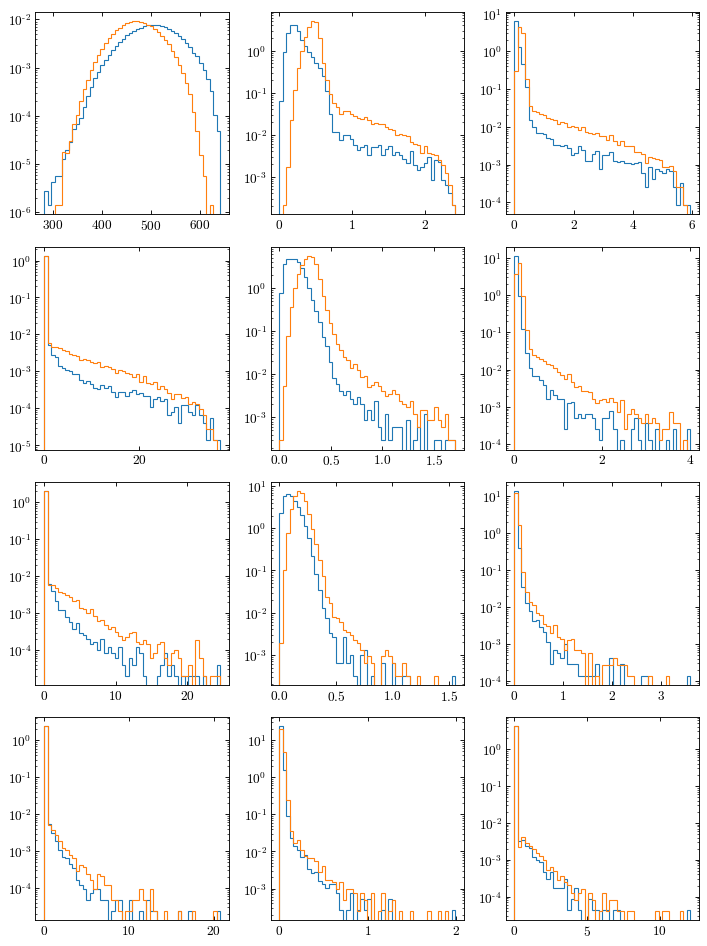

In [24]:
plt.figure(figsize=(9, 12))
qcd = NSubjettinessData[training_labels[:,0] == 0]
tops = NSubjettinessData[training_labels[:,0] == 1]
for i in range(12):
    plt.subplot(4, 3, i+1)
    tmp_qcd = qcd[:, i]
    tmp_qcd = tmp_qcd[tmp_qcd > 0]
    
    tmp_tops = tops[:, i]
    tmp_tops = tmp_tops[tmp_tops > 0]
    
    n, b, p = plt.hist(tmp_qcd, bins=50, density=True, histtype='step')
    plt.hist(tmp_tops, bins=b, density=True, histtype='step')
    plt.yscale('log')
    
plt.tight_layout()
plt.show()

In [25]:
np.save('../data/top_tagging/smaller_raw/nsubjettiness_training.npy', NSubjettinessData)
np.save('../data/top_tagging/smaller_raw/nsubjettiness_val.npy', NSubjettinessValData)
np.save('../data/top_tagging/smaller_raw/nsubjettiness_test.npy', NSubjettinessTestData)

## Images

Now, let's build the raw data into a series of images. We will use the [EnergyFlow](https://energyflow.network/) package for this. We will need to center, rotate, and reflect the fourvectors to take advantage of the natural symmetries.

In [26]:
from energyflow.utils import ptyphims_from_p4s
from energyflow.utils import center_ptyphims 
from energyflow.utils import rotate_ptyphims 
from energyflow.utils import reflect_ptyphims 
from energyflow.utils import phi_fix
from energyflow.utils import pixelate

### Convert

First, let's convert the four-vectors into $(p_t, \eta, \phi, m)$. This function works on a list of 4-vectors, so we will have to do a for loop over each event in the list.

In [27]:
training_ptyphims = []
for event in tqdm(training_events):
    training_ptyphims.append(ptyphims_from_p4s(event, phi_ref='hardest', mass=True))
training_ptyphims = np.array(training_ptyphims)
print(training_ptyphims.shape)

100% 200000/200000 [00:26<00:00, 7601.17it/s]


(200000, 100, 4)


In [28]:
val_ptyphims = []
for event in tqdm(val_events):
    val_ptyphims.append(ptyphims_from_p4s(event, phi_ref='hardest', mass=True))
val_ptyphims = np.array(val_ptyphims)
print(val_ptyphims.shape)

100% 20000/20000 [00:02<00:00, 8348.94it/s]

(20000, 100, 4)


In [29]:
test_ptyphims = []
for event in tqdm(test_events):
    test_ptyphims.append(ptyphims_from_p4s(event, phi_ref='hardest', mass=True))
test_ptyphims = np.array(test_ptyphims)
print(test_ptyphims.shape)

100% 20000/20000 [00:02<00:00, 9292.98it/s]

(20000, 100, 4)


### Center
Now we center the image by subtracting the mean $\eta, \phi$

In [30]:
training_ptyphims_center = []
for event in tqdm(training_ptyphims):
    training_ptyphims_center.append(center_ptyphims(event))
training_ptyphims_center = np.array(training_ptyphims_center)
print(training_ptyphims_center.shape)

100% 200000/200000 [00:43<00:00, 4567.91it/s]


(200000, 100, 4)


In [31]:
val_ptyphims_center = []
for event in tqdm(val_ptyphims):
    val_ptyphims_center.append(center_ptyphims(event))
val_ptyphims_center = np.array(val_ptyphims_center)
print(val_ptyphims_center.shape)

100% 20000/20000 [00:03<00:00, 5564.57it/s]

(20000, 100, 4)


In [32]:
test_ptyphims_center = []
for event in tqdm(test_ptyphims):
    test_ptyphims_center.append(center_ptyphims(event))
test_ptyphims_center = np.array(test_ptyphims_center)
print(test_ptyphims_center.shape)

100% 20000/20000 [00:03<00:00, 5848.56it/s]


(20000, 100, 4)


### Reflect and Rotate

In [33]:
training_ptyphims_center_rr = []
for event in tqdm(training_ptyphims_center):
    training_ptyphims_center_rr.append(reflect_ptyphims(rotate_ptyphims(event)))
training_ptyphims_center_rr = np.array(training_ptyphims_center_rr)
print(training_ptyphims_center_rr.shape)

100% 200000/200000 [01:14<00:00, 2696.51it/s]


(200000, 100, 4)


In [34]:
val_ptyphims_center_rr = []
for event in tqdm(val_ptyphims_center):
    val_ptyphims_center_rr.append(reflect_ptyphims(rotate_ptyphims(event)))
val_ptyphims_center_rr = np.array(val_ptyphims_center_rr)
print(val_ptyphims_center_rr.shape)

100% 20000/20000 [00:08<00:00, 2385.69it/s]

(20000, 100, 4)


In [35]:
test_ptyphims_center_rr = []
for event in tqdm(test_ptyphims_center):
    test_ptyphims_center_rr.append(reflect_ptyphims(rotate_ptyphims(event)))
test_ptyphims_center_rr = np.array(test_ptyphims_center_rr)
print(test_ptyphims_center_rr.shape)

100% 20000/20000 [00:14<00:00, 1387.99it/s]


(20000, 100, 4)


### Pixelate the images

In [36]:
training_images = []
for event in tqdm(training_ptyphims_center_rr):
    training_images.append(pixelate(event, 
                                    npix=33, 
                                    img_width=0.8, 
                                    nb_chan=1, 
                                    norm=False, 
                                    charged_counts_only=False))
training_images = np.array(training_images)
print(training_images.shape)

100% 200000/200000 [01:13<00:00, 2705.36it/s]


(200000, 33, 33, 1)


In [37]:
val_images = []
for event in tqdm(val_ptyphims_center_rr):
    val_images.append(pixelate(event, 
                               npix=33, 
                               img_width=0.8, 
                               nb_chan=1, 
                               norm=False, 
                               charged_counts_only=False))
val_images = np.array(val_images)
print(val_images.shape)

100% 20000/20000 [00:40<00:00, 498.91it/s] 


(20000, 33, 33, 1)


In [38]:
test_images = []
for event in tqdm(test_ptyphims_center_rr):
    test_images.append(pixelate(event, 
                                npix=33, 
                                img_width=0.8, 
                                nb_chan=1, 
                                norm=False, 
                                charged_counts_only=False))
test_images = np.array(test_images)
print(test_images.shape)

100% 20000/20000 [00:10<00:00, 1834.08it/s]


(20000, 33, 33, 1)


### Examples
Now let's look at a few example images from the training set. We will sort out a few top and a few qcd examples.

In [39]:
top_images = training_images[training_labels.flatten() == 1]
qcd_images = training_images[training_labels.flatten() == 0]

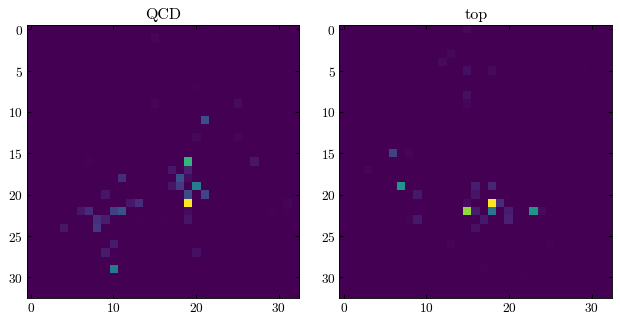

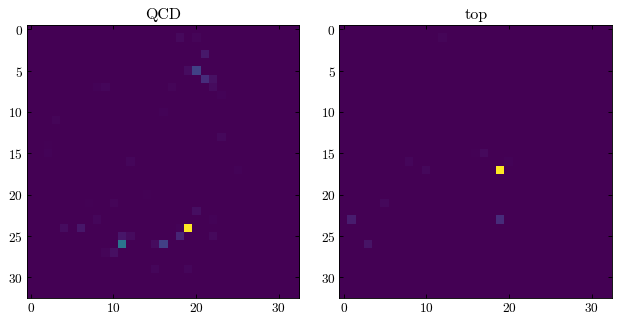

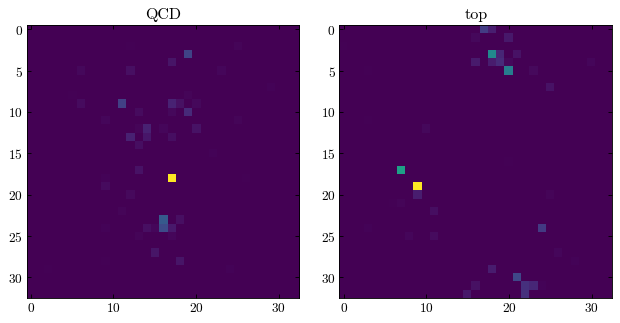

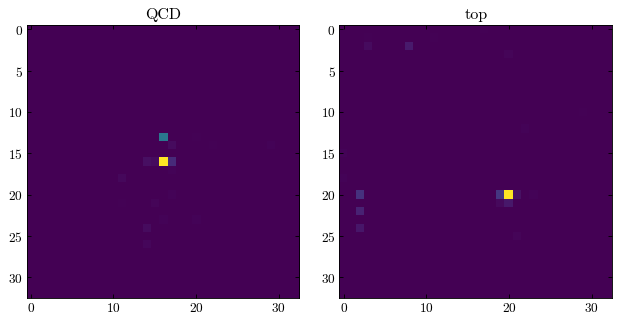

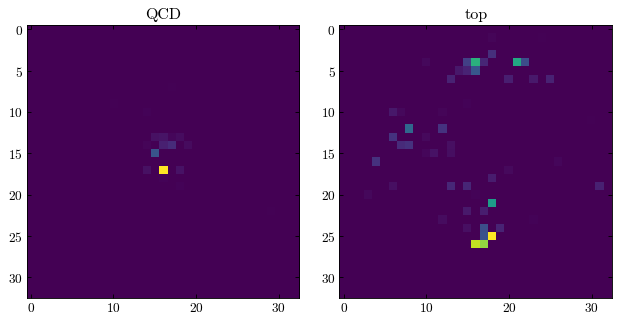

In [40]:
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('QCD')
    plt.imshow(qcd_images[i])
    plt.subplot(1, 2, 2)
    plt.title('top')
    plt.imshow(top_images[i])
    plt.tight_layout()
    plt.show()

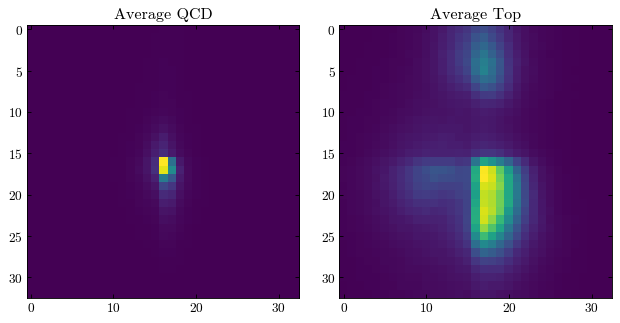

In [41]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.sum(qcd_images, axis=0))
plt.title('Average QCD')

plt.subplot(1, 2, 2)
plt.imshow(np.sum(top_images, axis=0))
plt.title('Average Top')

plt.tight_layout()
plt.show()

In [42]:
top_images.shape

(100000, 33, 33, 1)

In [43]:
np.max(top_images[1])

430.03980366172357

In [44]:
np.save('../data/top_tagging/smaller_raw/training_images.npy', training_images)
np.save('../data/top_tagging/smaller_raw/val_images.npy', val_images)
np.save('../data/top_tagging/smaller_raw/test_images.npy', test_images)